In this notebook, we evaluate the AutoEncoder at different ADC ranges

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import math
import tqdm

In [2]:
wireplane = 'U'
np.random.seed(42)

def filter_signal_ADC(data, clean_data, adc_value, filter_by_max):
    data_wf = []
    clean_wf = []
    for i in range(clean_data.shape[0]):
        if filter_by_max:
            if max(clean_data[i]) < adc_value or sum(clean_data[i]) == 0:
                data_wf.append(data[i])
                clean_wf.append(clean_data[i])
        else:
            if max(clean_data[i]) > adc_value or sum(clean_data[i]) == 0:
                data_wf.append(data[i])
                clean_wf.append(clean_data[i])
    data_wf = np.array(data_wf)
    clean_wf = np.array(clean_wf)
    return data_wf, clean_wf

Load testing set

In [3]:
x_test = np.load('../../processed_data/current/x_test_' + wireplane + '.npy')
y_test = np.load('../../processed_data/current//y_test_AE_' + wireplane + '.npy')
mean = np.load('../../latest_models/mean_' + wireplane + '_nu.npy')
std = np.load('../../latest_models/scale_' + wireplane + '_nu.npy')

_______________________________________________________________________________________________________________________________

In [4]:
x_test_scaled = (x_test-mean)/std

In [5]:
y_test_scaled = []
for i in range(len(y_test)):
    if sum(y_test[i]) == 0:
        y_test_scaled.append(y_test[i])
    else:
        scaled = (y_test[i]-mean)/std
        y_test_scaled.append(scaled)
y_test_scaled = np.array(y_test_scaled)


Load trained model

In [6]:
def custom_mse2(y_true, y_pred):

    return -1

In [47]:
cnn = load_model('../../latest_models/model_Uplane_nu.h5')

autoencoder0 = load_model("../../latest_models/model_AE_" + wireplane + 'plane_nu.h5')
autoencoder1 = load_model("../batch_size1_epochs_10" + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})
autoencoder2 = load_model("../batch_size1" + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})
autoencoder3 = load_model("../batch_size1_epochs_50" + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})  # ~ 20 epochs
autoencoder4 = load_model("../batch_size1_epochs_50_w1_1-w2_dot3" + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})  # ~ 10 epochs
autoencoder5 = load_model("../batch_size1_epochs_50_w1_1-w2_dot7" + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})  # ~ 20 epochs
autoencoder6 = load_model("../batch_size1_epochs_50_w1_1-w2_dot7_unfreeze_lastCNN_layer_" + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})  # ~ 15 epochs


In [48]:
tf.executing_eagerly()

True

In [57]:
cnn_pred = cnn.predict(x_test_scaled, batch_size=4096)
cnn_pred = cnn_pred.squeeze()

25/25 [==============================] - 0s 16ms/step


### let's see what the MSE is at the region where signal exists

In [58]:
%%time
predictions0 = autoencoder0.predict(x_test_scaled, batch_size=4096)
predictions0 = predictions0.reshape(predictions0.shape[0], predictions0.shape[1])

predictions1 = autoencoder1.predict(x_test_scaled, batch_size=4096)
predictions1 = predictions1.reshape(predictions1.shape[0], predictions1.shape[1])

predictions2 = autoencoder2.predict(x_test_scaled, batch_size=4096)
predictions2 = predictions2.reshape(predictions2.shape[0], predictions2.shape[1])

predictions3 = autoencoder3.predict(x_test_scaled, batch_size=4096)
predictions3 = predictions3.reshape(predictions3.shape[0], predictions3.shape[1])

predictions4 = autoencoder4.predict(x_test_scaled, batch_size=4096)
predictions4 = predictions4.reshape(predictions4.shape[0], predictions4.shape[1])

predictions5 = autoencoder5.predict(x_test_scaled, batch_size=4096)
predictions5 = predictions5.reshape(predictions5.shape[0], predictions5.shape[1])

predictions6 = autoencoder6.predict(x_test_scaled, batch_size=4096)
predictions6 = predictions6.reshape(predictions6.shape[0], predictions6.shape[1])

25/25 [==============================] - 1s 42ms/step
Wall time: 7.86 s


In [59]:
x_test_ = std*x_test_scaled+mean
y_test_ = np.load('../../processed_data/current//y_test_AE_' + wireplane + '.npy')  # make sure target is original/not scaled before

Plot predicted wave on top of target and input

In [60]:

pred0 = predictions0*std+mean
pred1 = predictions1*std+mean
pred2 = predictions2*std+mean
pred3 = predictions3*std+mean
pred4 = predictions4*std+mean
pred5 = predictions5*std+mean
pred6 = predictions6*std+mean

In [61]:
print(len(x_test_), len(y_test_), len(pred_))

100000 100000 100000


In [62]:
cnn_pred[0]

0.17652601

### DEBUG -- apply ADC-CUT

#### generate plots of model's prediction on top of input & clean target (ADC CUT APPLIED)

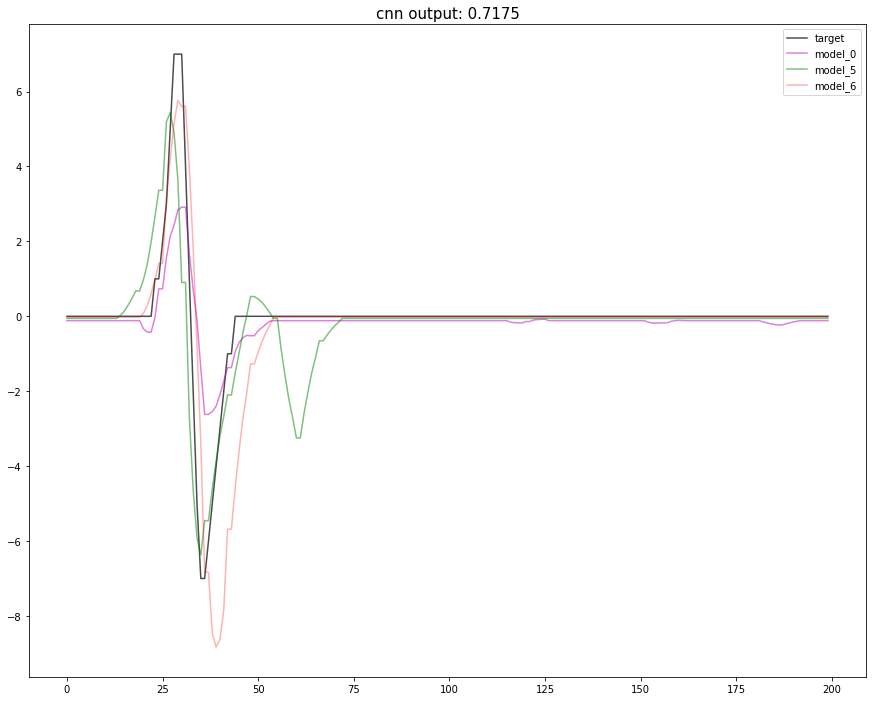

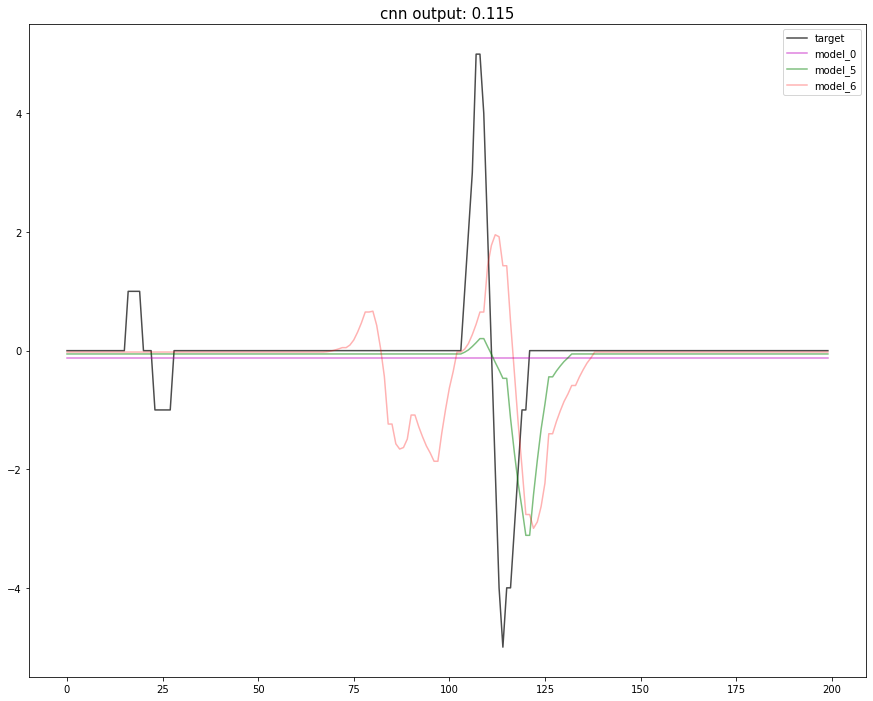

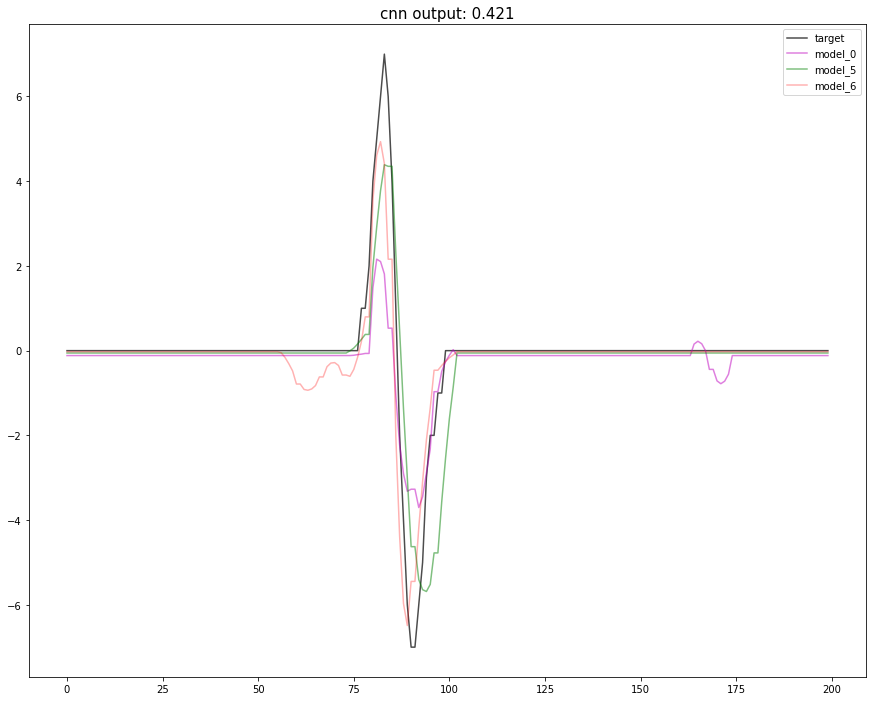

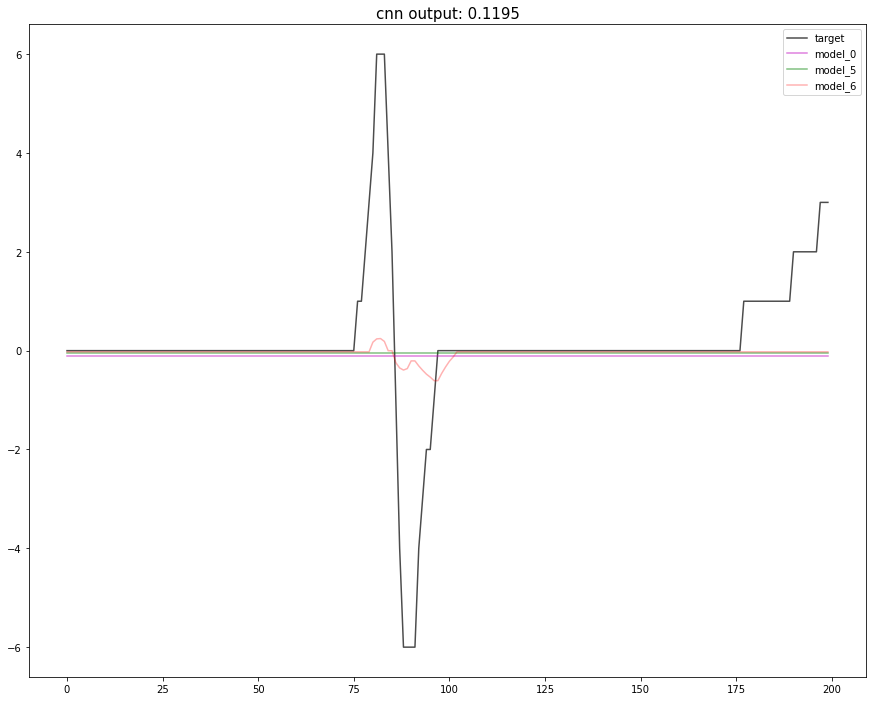

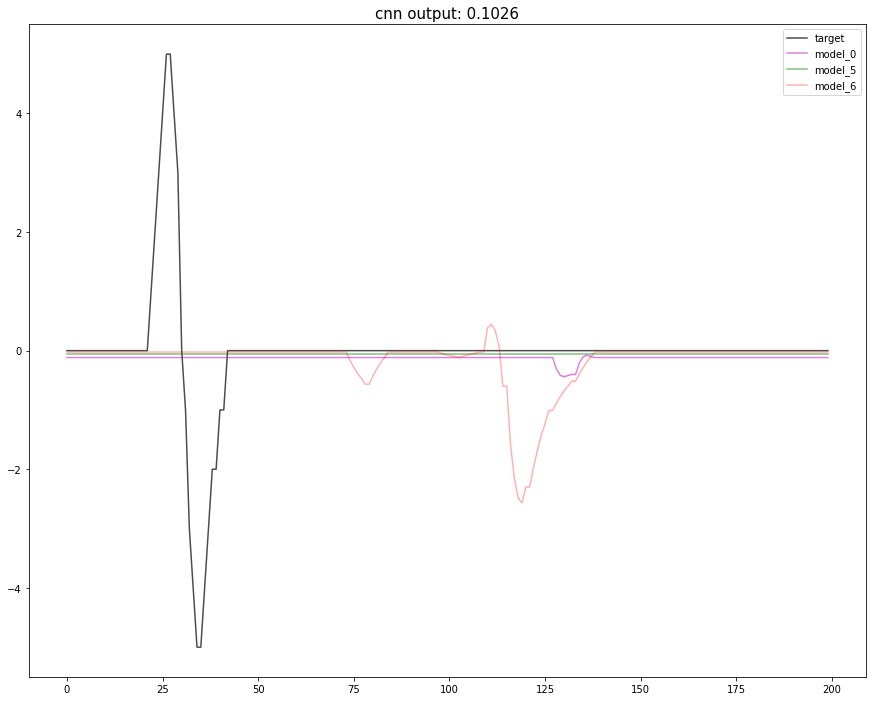

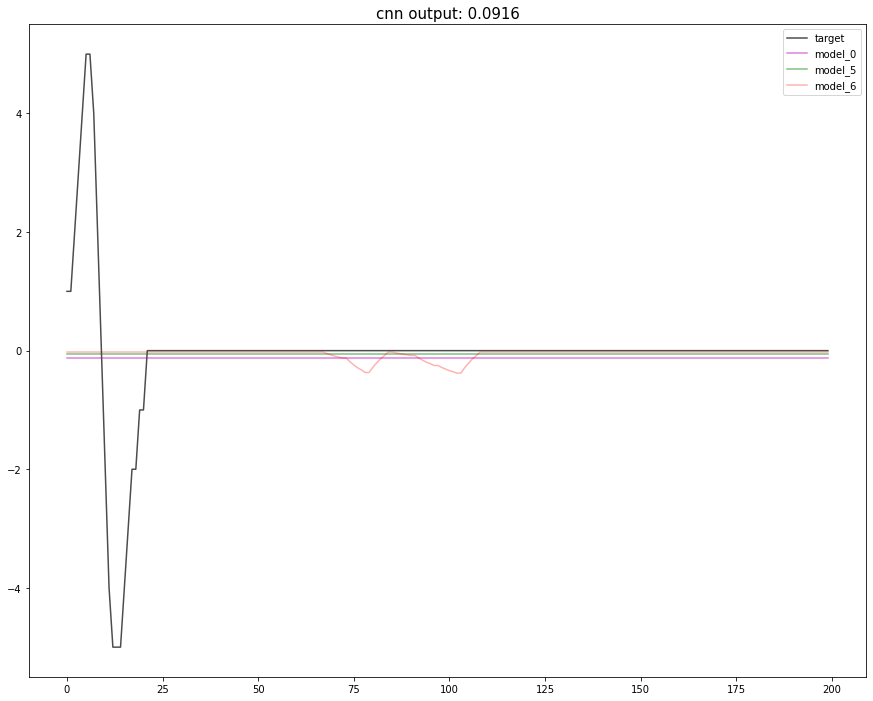

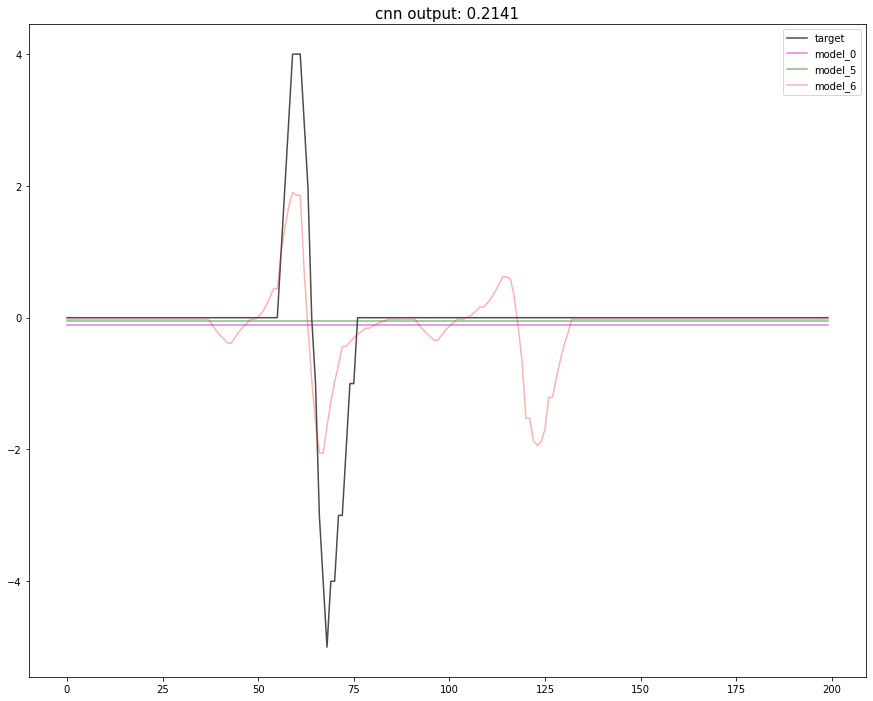

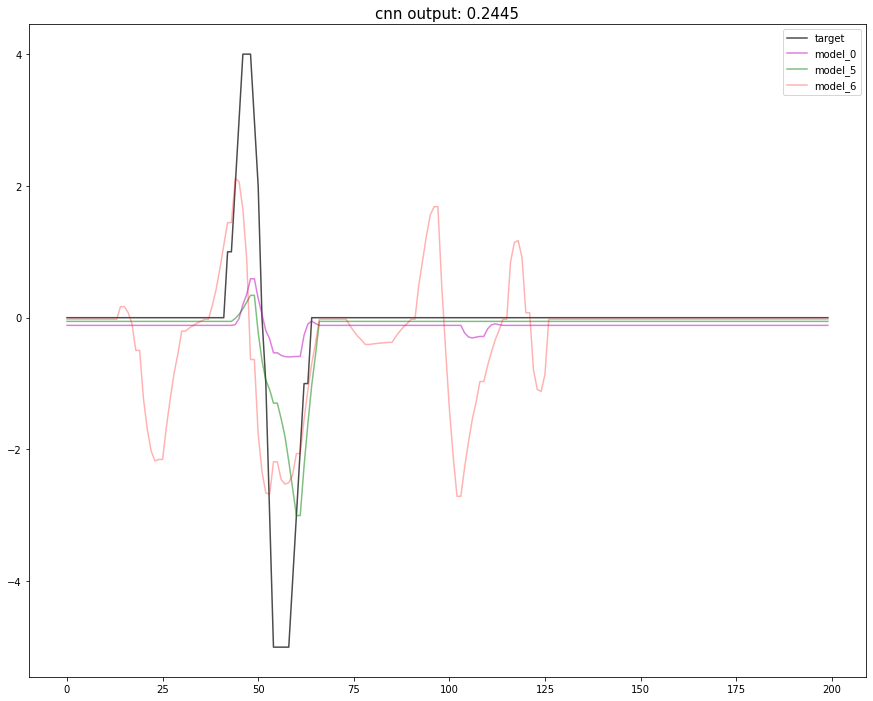

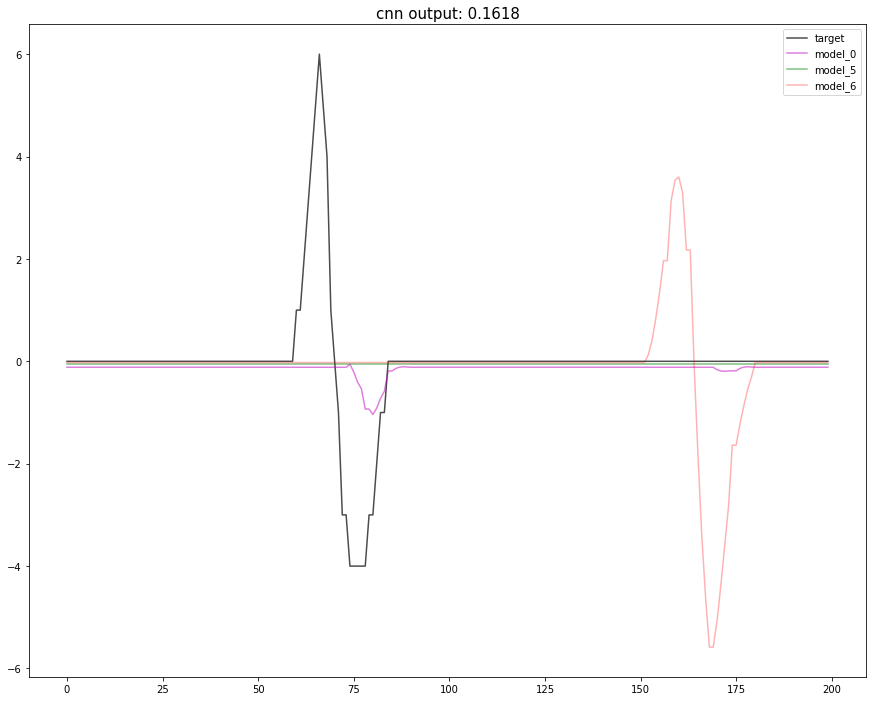

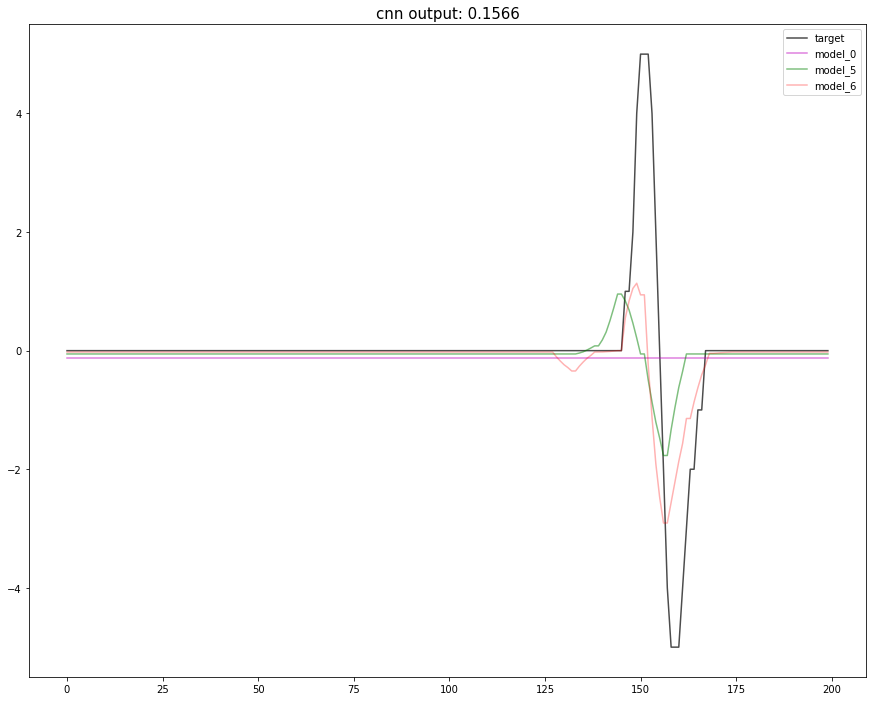

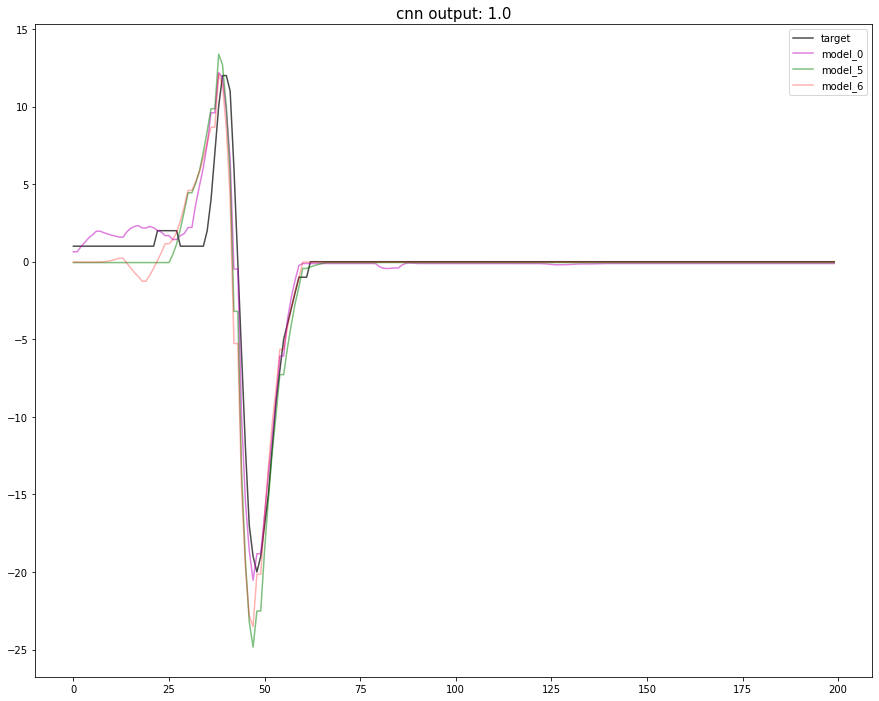

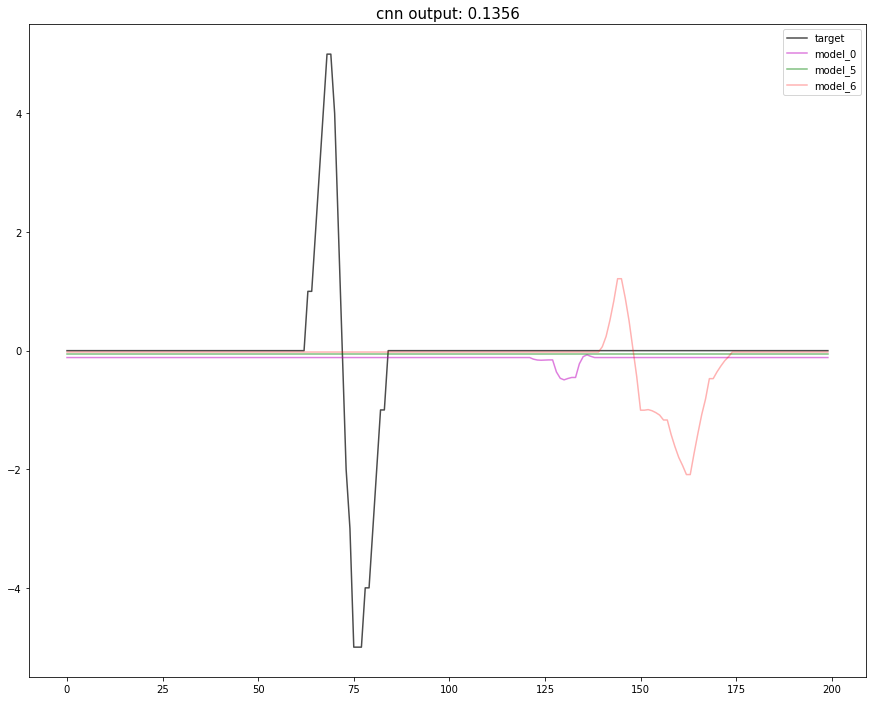

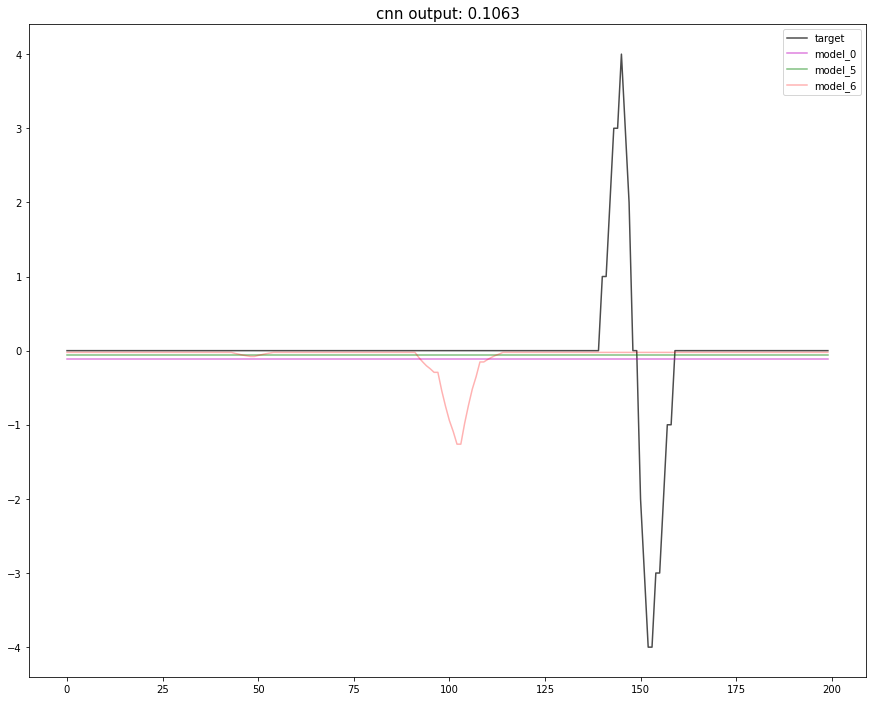

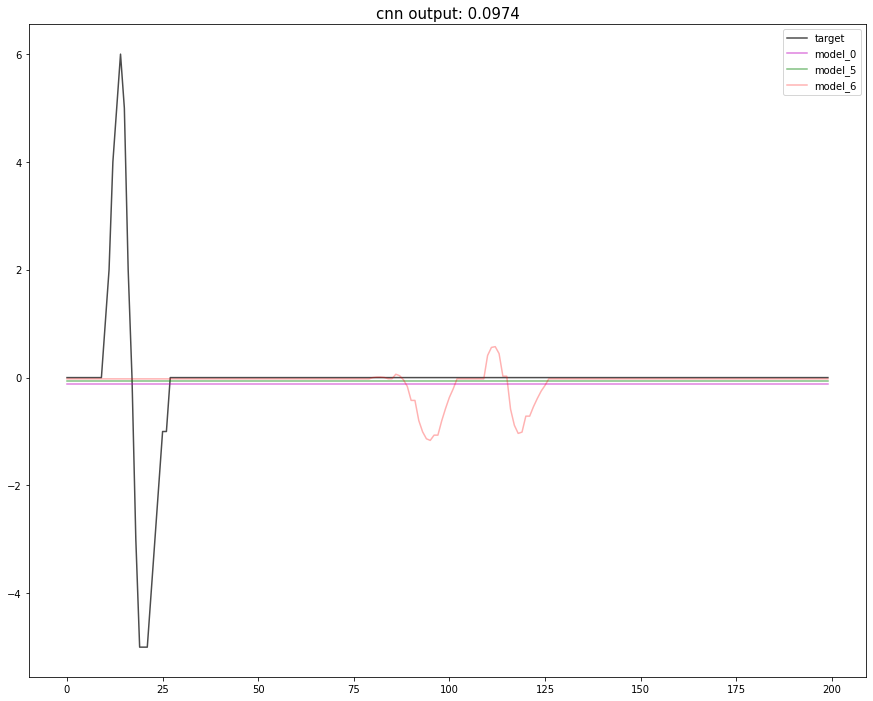

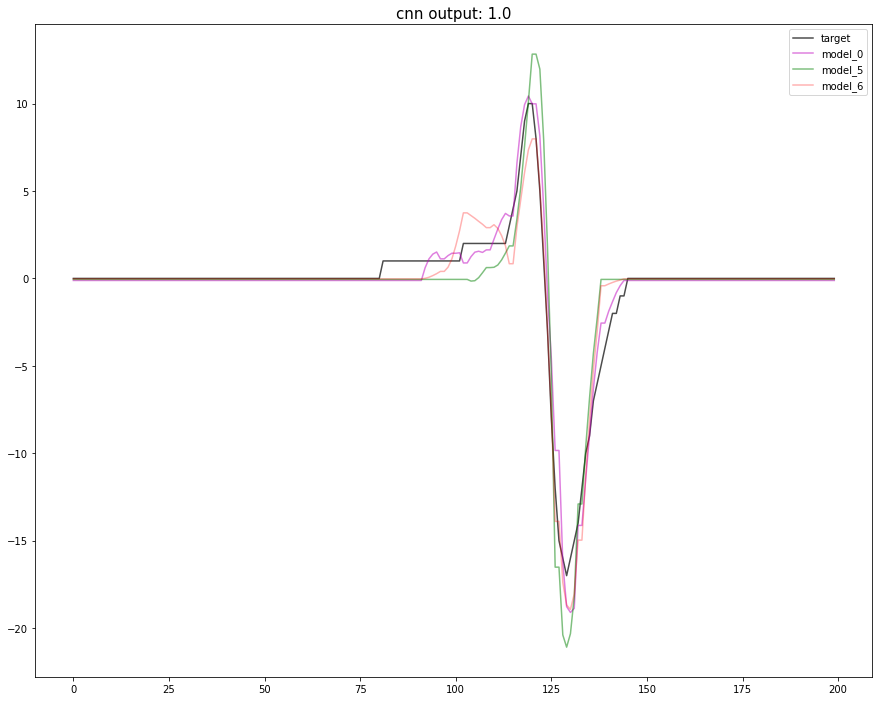

In [63]:
for idx in range(100):
    max_adc = int((max(x_test_[idx])))
    if sum(y_test_scaled[idx]) != 0:
        if max_adc < 15:
            fig, (ax1) = plt.subplots(figsize=(15, 12), facecolor='white')
            ax1.plot(y_test_[idx],color='black', label='target', alpha=0.7)
            #ax1.plot(x_test_[idx], color='black',alpha=0.2, label = 'original input (adc_max: ' + str(max_adc) + ')')

            ax1.plot(pred0[idx],color='m',alpha=0.5, label='model_0')
            #ax1.plot(pred1[idx],color='g',alpha=0.3, label='model_1')
            #ax1.plot(pred2[idx],color='r',alpha=0.3, label='model_2')
            #ax1.plot(pred3[idx],color='yellow',alpha=0.3, label='model_3')
            #ax1.plot(pred4[idx],color='orange',alpha=0.5, label='model_4')
            ax1.plot(pred5[idx],color='g',alpha=0.5, label='model_5')
            ax1.plot(pred6[idx],color='r',alpha=0.3, label='model_6')
            
            
            ax1.set_title("cnn output: " + str(round(cnn_pred[idx], 4)), fontsize=15)
            ax1.legend()
            #filename = 'plane_u_AE_plots_ADC_MAX_15_no_noise/'+str(idx)+'.png' 
            #plt.savefig(filename, facecolor='w')
            plt.show()

### DEBUG -- apply ADC-CUT -- NOT DONE

-----------------------------------------------------------------------------

#### generate plots of model's prediction on top of input & clean target (ALL)

In [ ]:
#for idx in range(len(x_test_)):
#    fig, (ax1) = plt.subplots(figsize=(12, 4), facecolor='white')
#    ax1.plot(y_test_[idx],color='blue', label='target')
#    ax1.plot(pred_[idx],color='m',alpha=0.7, label='model prediction')
#    ax1.plot(x_test_[idx], color='orange',alpha=0.7, label = 'original input')
#    ax1.set_title("trained using clean signals as target", fontsize=15)
#    ax1.legend()
#    filename = 'plane_u_AE_plots/'+str(idx)+'.png' 
#    plt.savefig(filename, facecolor='w')
#    plt.close()

Checkpoint reached

In [ ]:
# calculate MSE for the entire range
mse = np.mean((y_test_scaled - predictions)**2)
print("MSE for entire range:", mse)

### Calculate MSE with new ranges

In [ ]:
# helper to calculate mse of segments or full wave
def calculate_single_mse_helper(seqment_wave, seqment_pred_wave):
    single_mse = np.mean((seqment_wave-seqment_pred_wave)**2)
    return single_mse

In [ ]:
# helper to calculate mse of segments or full wave
def calculate_single_mse_helper(seqment_wave, seqment_pred_wave):
    single_mse = np.mean((seqment_wave-seqment_pred_wave)**2)
    return single_mse

# helper method to calculate mse given some ranges
def segment_mse_helper(expected, prediction, wave_ranges, flag):
    expected_waves = []
    pred_waves = []
    mses = []

    for range_ in wave_ranges:
        expected_wave = expected[range_[0]:range_[1]]
        pred_wave = prediction[range_[0]:range_[1]]
        curr_mse = calculate_single_mse_helper(expected_wave, pred_wave)
        if flag:
            print('signal region--> range:', range_, ' mse:',curr_mse)
        else:
            print('non-signal region--> range:', range_, ' mse:',curr_mse)
        mses.append(curr_mse)
    
    mse = sum(mses)
    return mse

def calculate_single_mse(expected, prediction, signal_ranges, non_signal_ranges):
    print('signal ranges: ', str(signal_ranges),'non_signal ranges: ', str(non_signal_ranges))
    
    signal_region = 0
    full_window = calculate_single_mse_helper(expected, prediction)
    no_signal_region = 0
    print("full window :", full_window)
    
    if sum(expected) != 0:
        signal_region = segment_mse_helper(expected, prediction, signal_ranges, True)
        no_signal_region = segment_mse_helper(expected, prediction, non_signal_ranges, False)

        print('signal region: ', signal_region)
        print('non-signal region: ', no_signal_region)

    return [full_window, signal_region, no_signal_region] 

In [ ]:
index = 5
ex = y_test_scaled[index]
pred = predictions[index]
rng = ranges[index]

In [ ]:

print(calculate_single_mse(ex, pred, rng,get_non_signal_ranges(rng)))
fig = plt.figure(figsize=(10,2))
plt.plot(ex, label="target")
plt.plot(pred, label="prediction")
plt.legend()
plt.show()

In [ ]:

tes_ex = ex[rng[0][0]:rng[0][1]]
tes_pred = pred[rng[0][0]:rng[0][1]]
fig = plt.figure(figsize=(10,2))
plt.plot(tes_ex, label="target")
plt.plot(tes_pred, label="prediction")
plt.legend()
plt.show()
print(calculate_single_mse_helper(tes_ex, tes_pred))

In [ ]:
i=5
ex = y_test_scaled[i]
pred = predictions[i]
rng = ranges[i]
wave_mse = calculate_single_mse(ex, pred, rng, get_non_signal_ranges(rng))
for i in range(3):
    print(wave_mse[i], i)
# runtime ~ 2min
print(wave_mse)

#### calculate MSES for entire test set

In [ ]:
full = []
signal = []
no_signal = []
for i in range(len(ranges)):
    ex = y_test_scaled[i]
    pred = predictions[i]
    rng = ranges[i]
    wave_mse = calculate_single_mse(ex, pred, rng, get_non_signal_ranges(rng))
    full.append(wave_mse[0])
    signal.append(wave_mse[1])
    no_signal.append(wave_mse[2])
# runtime ~ 2min

In [ ]:
print(any([math.isnan(x) for x in full]), any([math.isnan(x) for x in signal]), any([math.isnan(x) for x in no_signal]))
print(len(full), len(signal), len(no_signal))

### RESULT

In [ ]:
print('Total MSE (mean) - full window:        ', np.mean(full))
print('Total MSE (mean) - signal region:      ', np.mean(signal))
print('Total MSE (mean) - non-signal region:  ', np.mean(no_signal))

### Calculate MSE with new ranges ---  DONE

______________________________________________________________________________________________________________________

### GENERATE PLOTS with 1DCNN FLAGS + MSE INFO

In [ ]:
model_1dcnn = load_model('../latest_models/model_' + wireplane + 'plane_nu.h5')

In [ ]:
y_test_ROI = np.load('../processed_data/current/y_test_ROI_' + wireplane + '.npy')

In [ ]:
x_test_scaled_ROI = np.array(x_test_scaled)
all_infer = model_1dcnn.predict(x_test_scaled_ROI, batch_size=4096)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_ROI, all_infer)
plt.figure(figsize=(8, 4))  
plt.plot(fpr_keras, tpr_keras, label='auc: ' + str(round(auc(fpr_keras, tpr_keras), 3)))
plt.title("ROC Curve - Test Dataset Plane " + wireplane)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='center')

In [ ]:
pred_ROI = all_infer.squeeze()
print(pred_ROI.shape)

In [ ]:
for idx in range(100):
    fig, (ax1) = plt.subplots(figsize=(20, 15), facecolor='white')
    ax1.plot(y_test_[idx],color='blue', label='target')
    ax1.plot(pred_[idx],color='m',alpha=0.7, label='model prediction')
    ax1.plot(x_test_[idx], color='orange',alpha=0.7, label = 'original input')
    ax1.set_title("trained using clean signals as target", fontsize=20)
    ax1.legend(fontsize=20)
    plt.figtext(0.9125, 0.75, 'ROI pred: ' + str(np.round(pred_ROI[idx],5)), fontsize=20)
    plt.figtext(0.9125, 0.7, 'ROI truth: ' + str(np.round(y_test_ROI[idx],5)), fontsize=20)
    plt.figtext(0.9125, 0.65, 'MSE (full): ' + str(np.round(full[idx],5)), fontsize=20)
    plt.figtext(0.9125, 0.6, 'MSE (sig): ' + str(np.round(signal[idx],5)), fontsize=20)
    plt.figtext(0.9125, 0.55, 'MSE (no_sig): ' + str(np.round(no_signal[idx],5)), fontsize=20)
    plt.xlabel('time', fontsize=20)
    plt.ylabel('ADC', fontsize=20)
    #filename = 'plane_u_mega_plots/'+str(idx)+'.png' 
    #plt.savefig(filename, facecolor='w', bbox_inches='tight')

    plt.show()



### GENERATE PLOTS with 1DCNN FLAGS + MSE INFO -- NOT COMPLETE

-----------------------------------------------------------------------------------------------------------------------------

### BELOW -- NEED TO LOOK AT AGAIN

Next: at the moment MSEs are being calculating for just one range. However there are waves with multiple ranges. We need to take this into account

In [ ]:
print(calculate_single_mse(x_test_scaled[0], predictions[15]))

NOTE: MSE IS CALCULATED FOR ONE WAVE. NEED TO LOOP TO GET ALL WAVES

In [ ]:
# adc_max = 0 means no max cut is applied
def eval_cut_(x_test_, y_test_, adc_min, adc_max):
    print(x_test_.shape, y_test_.shape)

    test_, clean_ =  filter_signal_ADC(x_test_, y_test_, adc_min, False)
    print(test_.shape, clean_.shape)
    if adc_max != 0:
        test_, clean_ =  filter_signal_ADC(test_, clean_, adc_max, True)
    print(test_.shape, clean_.shape)


    x_test_scaled_ = (x_test_-mean)/std
    clean_scaled_ = clean_
    
    y_test_scaled_ = []
    for i in range(len(y_test_)):
        if sum(y_test_[i]) == 0:
            y_test_scaled_.append(y_test_[i])
        else:
            scaled_ = (y_test_[i]-mean)/std
            y_test_scaled_.append(scaled_)
    y_test_scaled_ = np.array(y_test_scaled_)


    all_pred = autoencoder.predict(x_test_scaled, batch_size=4096)
    all_pred = all_pred.reshape(all_pred.shape[0], all_pred.shape[1])

    MSES_ = []
    nan_idxs_ = []
    for idx in range(len(y_test_scaled)):
        mse_ = calculate_single_mse(y_test_scaled[idx], all_pred[idx])

        if not np.isnan(mse_):
            MSES.append(mse_)
        else:
            nan_idxs_.append(idx)
    return MSES, nan_idxs_

In [ ]:
mse_3_15 = []
nans_3_15 = []
for i in range(3, 16):
    eval_cut_(x_test, y_test, i, 0)
    mses_, nans = eval_cut_(x_test, y_test, i, 0)
    mse_3_15.append([mses_])
    nans_3_15.append([nans])


In [ ]:
print(len(mse_3_15), len(nans_3_15))

In [ ]:
mse_3_15